# The Ising model

In [1]:
import matplotlib as plt
import numpy as np
import random as rn
%matplotlib inline
from pylab import *

In [2]:
class ising_model:
    def __init__(self, size, temp, steps):
        '''
        Initialize the parameters of the system
        '''
        self.size = size
        self.temp = temp
        self.steps = steps
        self.time = 0
        
    def initialize(self):
        '''
        Initialize a random configuration of the system
        '''
        self.state = np.random.choice([-1, 1], size=(self.size, self.size))
    
    def update(self):
        '''
        Update a randomly chosen cell according to the rules
        '''
        # Choose a random cell from the lettice
        x, y = np.random.choice(range(self.size), 2)
        neighbors = 0
        for dx,dy in [[1,0],[0,1],[-1,0],[0,-1]]:
            neighbors += self.state[(x + dx) % self.size, (y + dy) % self.size]
        E = -1 * self.state[x, y] * neighbors
        prob = min(1, np.exp((2*E)/self.temp))
        if prob > rn.random():
            self.state[x, y] = -1 * self.state[x, y]
        self.time += 1
        
    def observe(self):
        '''
        Plot the configuration of the system
        '''
        plt.title('Temperature = {}\nIsing model after {}'.format(self.temp, self.time))
        imshow(self.state, vmin=-1, vmax=1)
        
    def run(self):
        '''
        Run the simulation
        '''
        for _ in range(self.steps):
            self.update()
            
    def avg_magnetization(self):
        return self.state.mean()

980 ms ± 47.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Average magnetization of the system:  -0.0712


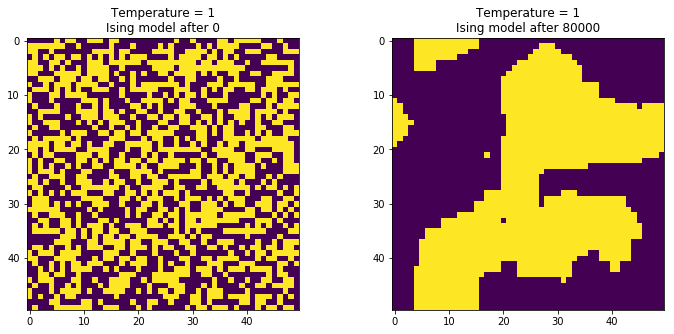

918 ms ± 52.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Average magnetization of the system:  0.16


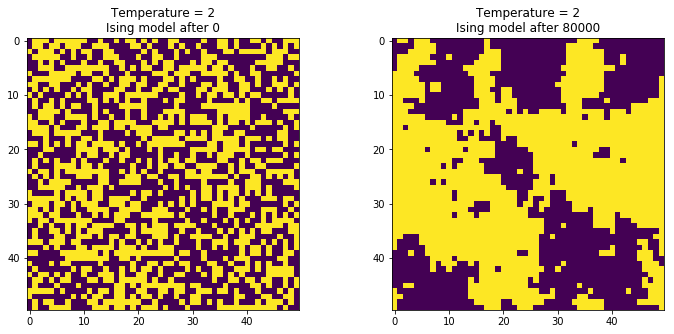

971 ms ± 32.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Average magnetization of the system:  -0.0344


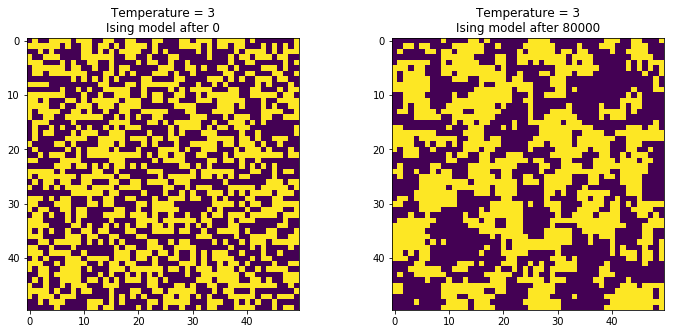

947 ms ± 52.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Average magnetization of the system:  0.0304


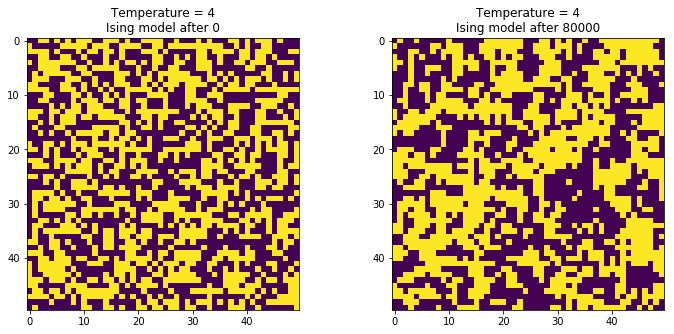

982 ms ± 50 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Average magnetization of the system:  -0.0088


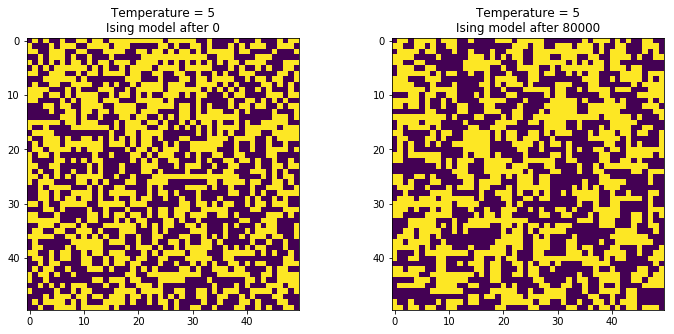

In [3]:
for T in [1, 2, 3, 4, 5]:
    sim = ising_model(50, T, 10**4)
    sim.initialize()
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    sim.observe()
    plt.subplot(1,2,2)
    %timeit sim.run()
    print('Average magnetization of the system: ', sim.avg_magnetization())
    sim.observe()
    plt.show()

In [6]:
temp_record = []
for T in [1, 2, 3, 4, 5]:
    for _ in range(100):
        sim = ising_model(50, T, 10**4)
        sim.initialize()
        sim.run()
        temp_record.append(sim.avg_magnetization())
    print(' Processing T = {}'.format(T))

 Processing T = 1
 Processing T = 2
 Processing T = 3
 Processing T = 4
 Processing T = 5


In [7]:
temp_record = np.array(temp_record).reshape(5, 100)

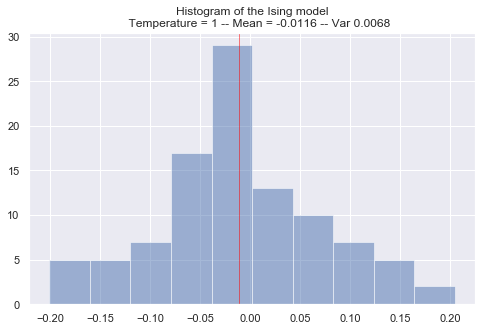

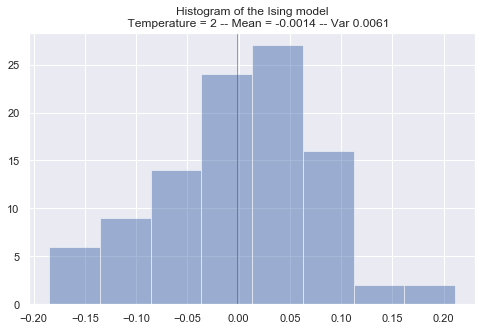

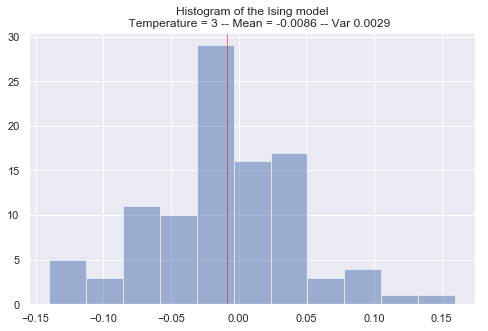

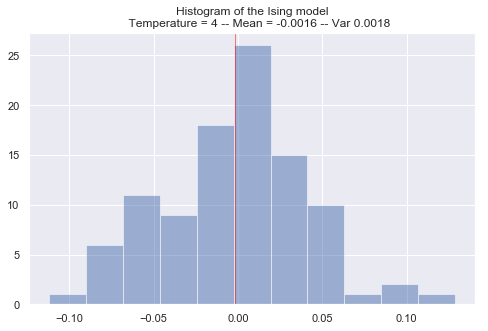

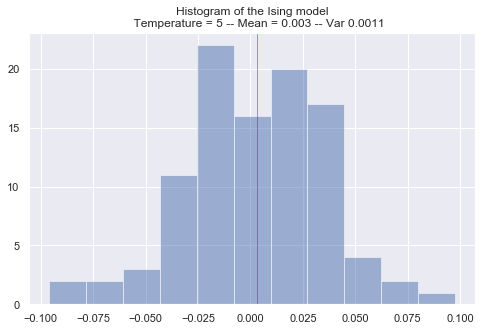

In [8]:
import seaborn as sns
sns.set()

for T in [1, 2, 3, 4, 5]:
    plt.figure(figsize=(8, 5))
    mean = round(np.mean(temp_record[T-1]), 4)
    var = round(np.var(temp_record[T-1]), 4)
    plt.title('''Histogram of the Ising model
    Temperature = {} -- Mean = {} -- Var {}'''.format(T, mean, var))
    plt.hist(temp_record[T-1], bins='auto', alpha=.5)
    plt.axvline(np.mean(temp_record[T-1]), color='red', linewidth=.5)
    plt.show()

# Ising model with Cython

<code>Code ispired by: </code> http://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/

In [15]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [16]:
%%cython
import matplotlib as plt
cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)

def cy_ising_step(long[:, :] field, int temp=2):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _cy_ising_update(field, n, m, temp)
    return np.array(field)


@cython.boundscheck(False)
@cython.wraparound(False)

cdef _cy_ising_update(long[:, :] field, int n, int m, int temp):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int i, j
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    cdef float dE = 2 * field[n, m] * total
    if exp(-dE / temp) * RAND_MAX > rand():
        field[n, m] *= -1

In [17]:
field = np.random.choice([-1, 1], size=(100, 100))
%timeit cy_ising_step(field)

1.62 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Ising model for temerature = 1


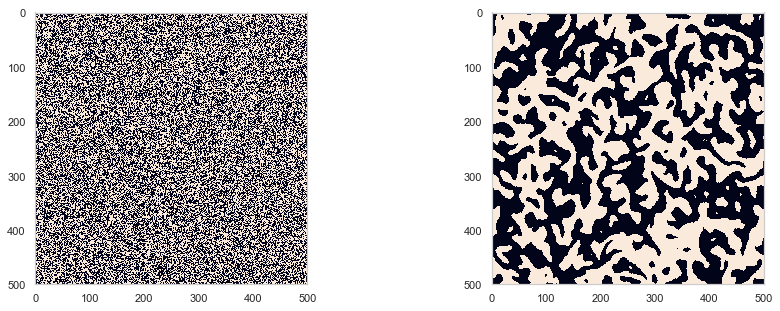

Ising model for temerature = 2


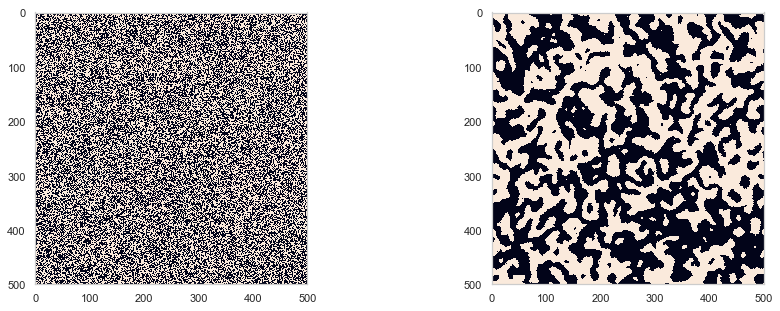

Ising model for temerature = 3


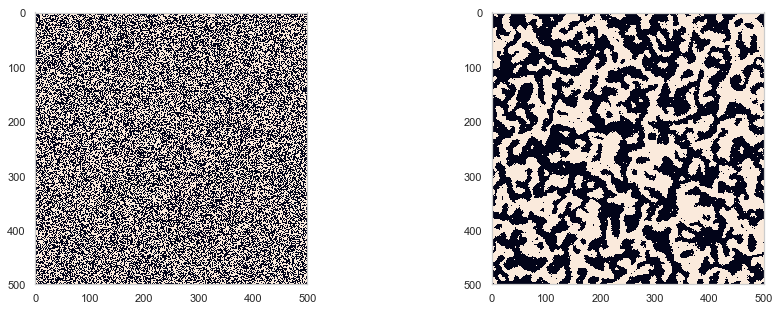

Ising model for temerature = 4


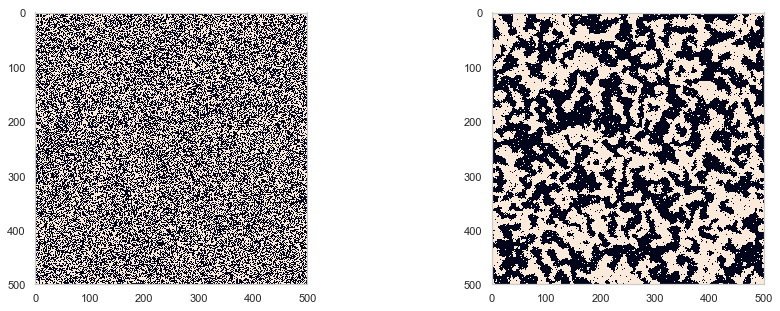

Ising model for temerature = 7


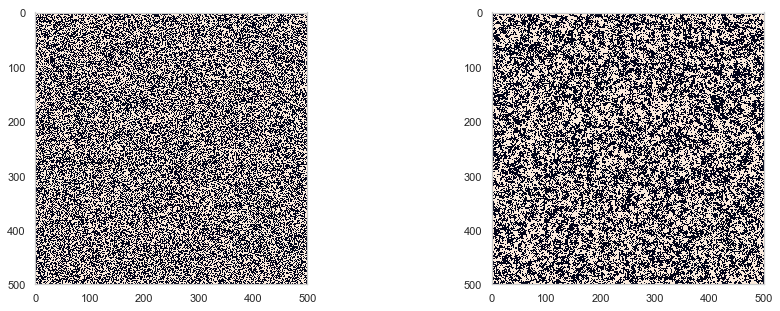

In [20]:
from pylab import *
sns.set_style("whitegrid", {'axes.grid' : False})
for T in [1, 2, 3, 4, 7]:
    record = [np.random.choice([-1, 1], size=(500, 500))]
    print('Ising model for temerature = {}'.format(T))
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    imshow(record[0], vmin=-1, vmax=1)
    plt.subplot(1,2,2)
    for i in range(10):
        record.append(cy_ising_step(record[-1].copy(), temp=T))
    imshow(record[-1], vmin=-1, vmax=1)
    plt.show()